In [1]:
import os
import time

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from floquet_analysis.transmon_floquet_simulator import TransmonFloquetSimulator
from floquet_analysis.transmon_resonator_fitter import TransmonResonatorFitter
from joblib import Parallel, delayed

In [2]:
# Measured frequencies
f01_meas = 3.845965050
f12_meas = 3.602264855

fr0_meas = 6.065852884
fr1_meas = 6.064931745
fr2_meas = 6.064094073

fitter = TransmonResonatorFitter(f01_meas, f12_meas, fr0_meas, fr1_meas, fr2_meas)

EJ_fitted, EC_fitted, fr_fitted, g_fitted = fitter.fit_parameters()

fitter.print_results()

Initial guess for [EJ, EC, fr, g]: [8.578861527050124, 0.24370019500000017, 6.0653923145, np.float64(0.09103399089132334)]

--- Fitting Results ---
Fitted EJ: 9.8266 GHz
Fitted EC: 0.2106 GHz
Fitted Resonator Freq (bare, f_r): 6.0650 GHz
Fitted Coupling Strength (g): 0.1017 GHz

Fitted Frequencies (from model with fitted parameters):
  Qubit f01: 3.8460 GHz
  Qubit f12: 3.6023 GHz
  Resonator freq @ Qubit |0>: 6.0650 GHz
  Resonator freq @ Qubit |1>: 6.0650 GHz
  Resonator freq @ Qubit |2>: 6.0650 GHz

Measured Frequencies (input data):
  Qubit f01: 3.8460 GHz
  Qubit f12: 3.6023 GHz
  Resonator freq @ Qubit |0>: 6.0659 GHz
  Resonator freq @ Qubit |1>: 6.0649 GHz
  Resonator freq @ Qubit |2>: 6.0641 GHz

Total Squared Error: 1.55e-06


Avg Excitation: 100%|██████████| 101/101 [00:04<00:00, 22.96it/s]


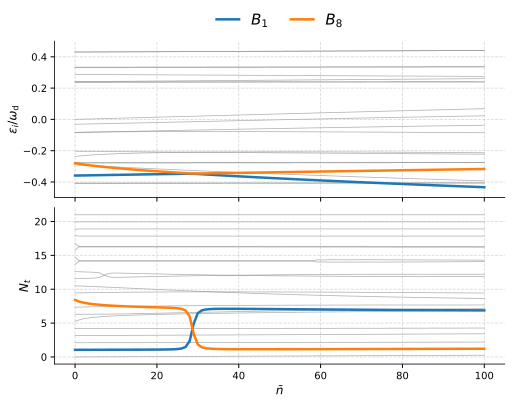

delta -2.397735819402644
n_r_critical 27


In [3]:
# Define parameters for the Floquet simulation
Ec = EC_fitted * 2 * np.pi
EjEc = EJ_fitted / EC_fitted
N = 10  # Charge basis truncation
w_d = 6* 2 * np.pi  # GHz (Drive frequency)

# Define the range of resonator photon numbers
n_r_list_sim = np.linspace(0, 100, 101)
g_strength_sim = g_fitted * 2 * np.pi  # Coupling strength in GHz

# Initialize the simulator
simulator = TransmonFloquetSimulator(Ec, EjEc, N, w_d, g_strength_sim, n_r_list_sim, ng=0)

result = simulator.find_n_r_critical(branch_index=1, branches_to_plot=[1, 8])
state_energy = simulator.bare_eigenenergies[2] - simulator.bare_eigenenergies[1]
print("delta", (state_energy - w_d) / (2 * np.pi))
print("n_r_critical", result)

In [4]:
ng = np.linspace(0, 0.5, 51)
w_d = np.linspace(4, 11, 701) * 2 * np.pi

state_to_inspect = 1


def func_to_parallelize(ng_val, w_d_val):
    simulator_tmp = TransmonFloquetSimulator(Ec, EjEc, N, w_d_val, g_strength_sim, n_r_list_sim, ng_val)

    n_critical_for_this_ng = simulator_tmp.find_n_r_critical(state_to_inspect, plot=False)
    state_energy = simulator_tmp.bare_eigenenergies[state_to_inspect + 1] - simulator_tmp.bare_eigenenergies[
        state_to_inspect]
    return n_critical_for_this_ng, (state_energy - w_d_val) / (2 * np.pi), ng_val


all_results = []
all_filtered_results = []
result_min = []
result_max = []
result_ng0 = []
for w_d_val in tqdm(w_d, desc="Finding n_r_critical for different n_g and resonator frequencies"):
    result = Parallel(n_jobs=-1)(
        delayed(func_to_parallelize)(ng_val, w_d_val)
        for ng_val in ng
    )
    # remove nans
    result_filtered = [sublist for sublist in result if not any(np.isnan(item) for item in sublist)]

    all_results.append(result)
    all_filtered_results.append(result_filtered)
    if result_filtered:
        result_ng0 += [result_filtered[0]]
        result_min += [min(result_filtered, key=lambda x: x[0])]
        result_max += [max(result_filtered, key=lambda x: x[0])]

result_min = np.array(result_min)
result_max = np.array(result_max)
result_ng0 = np.array(result_ng0)

time_string = time.strftime("%Y%m%d-%H%M%S")
filename = f"n_critical_wd-5-12-301_n_r_0-300-201-{time_string}.npy"

with open(filename, "wb") as f:
    np.save(f, result_min)
    np.save(f, result_max)
    np.save(f, result_ng0)
    np.save(f, all_results)

n_critical_min = result_min[:, 0]
n_critical_max = result_max[:, 0]
n_critical_ng0 = result_ng0[:, 0]
delta_ng0 = result_ng0[:, 1]

Finding n_r_critical for different n_g and resonator frequencies:   0%|          | 3/701 [02:52<11:12:07, 57.78s/it]capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.
Finding n_r_critical for different n_g and resonator frequencies:   0%|          | 3/701 [03:47<14:43:04, 75.91s/it]


KeyboardInterrupt: 

In [ ]:
# filename = "n_critical_wd-5-10-301_n_r_0-10-101_ng-1_new.npy"
with open(filename, "rb") as f:
    result_min_loaded = np.load(f)
    result_max_loaded = np.load(f)
    result_ng0_loaded = np.load(f)
    all_results_loaded = np.load(f)

fig, axs = plt.subplots(1, 1, figsize=(7, 5.5), sharex=True, dpi=300)

axs.set_xlabel(r'$\Delta/2\pi$ (GHz)')
axs.set_ylabel(r'$\bar{n}_\text{c}$')
axs.grid(True, linestyle='--', alpha=0.5)
axs.set_yscale("log")

axs.plot(result_ng0_loaded[:, 1], result_min_loaded[:, 0],
         label=r"Minimal $\bar{n}_\text{c} \; \text{for} \; n_g\in[0, 0.5]$")
axs.fill_between(result_ng0_loaded[:, 1], result_min_loaded[:, 0], result_max_loaded[:, 0], alpha=0.3)
plt.savefig("detuning_nc_with_ng_4.png")
plt.legend()
plt.show()

In [ ]:
result_min_loaded

In [ ]:
fr0_meas = 6.065852884
fr1_meas = 6.064931745
print("fr =", (fr0_meas + fr1_meas) / 2)
print("2*chi/2pi =", abs(fr0_meas - fr1_meas))

In [ ]:
result_min_loaded

In [ ]:
f12_meas + 6.157617

In [ ]:
for ng_val in ng:
    # Define parameters for the Floquet simulation
    Ec = EC_fitted * 2 * np.pi
    EjEc = EJ_fitted / EC_fitted
    N = 10  # Charge basis truncation
    w_d = 9.759881855* 2 * np.pi  # GHz (Drive frequency)

    # Define the range of resonator photon numbers
    n_r_list_sim = np.linspace(0, 100, 101)
    g_strength_sim = g_fitted * 2 * np.pi  # Coupling strength in GHz

    # Initialize the simulator
    simulator = TransmonFloquetSimulator(Ec, EjEc, N, w_d, g_strength_sim, n_r_list_sim, ng=ng_val)

    result = simulator.find_n_r_critical(branch_index=1)
    state_energy = simulator.bare_eigenenergies[2] - simulator.bare_eigenenergies[1]
    print("delta", (state_energy - w_d) / (2 * np.pi))
    print("n_r_critical", result)